In [4]:
# 📦 Install dependencies (TensorFlow and Addons)
!pip install -q tensorflow tensorflow-addons

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/monet_tfrec" /content/
!cp -r "/content/drive/MyDrive/Colab Notebooks/photo_tfrec" /content/

In [7]:
!ls /content/monet_tfrec
!ls /content/photo_tfrec


monet00-60.tfrec  monet08-60.tfrec  monet16-60.tfrec
monet04-60.tfrec  monet12-60.tfrec
photo00-352.tfrec  photo05-352.tfrec  photo10-352.tfrec  photo15-352.tfrec
photo01-352.tfrec  photo06-352.tfrec  photo11-352.tfrec  photo16-352.tfrec
photo02-352.tfrec  photo07-352.tfrec  photo12-352.tfrec  photo17-352.tfrec
photo03-352.tfrec  photo08-352.tfrec  photo13-352.tfrec  photo18-352.tfrec
photo04-352.tfrec  photo09-352.tfrec  photo14-352.tfrec  photo19-350.tfrec


Step 1: Setup, loading and preview images from both folder (EDA)

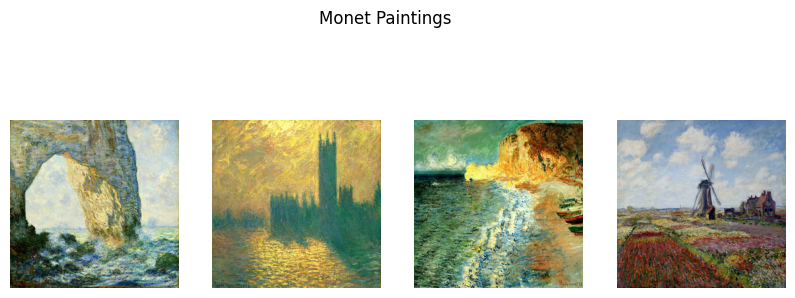

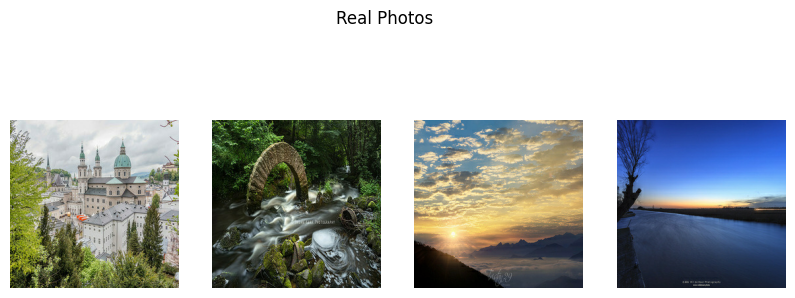

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Path to your TFRecord files
monet_tfrec_dir = "./monet_tfrec"
photo_tfrec_dir = "./photo_tfrec"

# List TFRecord files
monet_tfrecs = tf.io.gfile.glob(os.path.join(monet_tfrec_dir, "*.tfrec"))
photo_tfrecs = tf.io.gfile.glob(os.path.join(photo_tfrec_dir, "*.tfrec"))

# Parse function
def decode_image(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Normalized to [-1, 1]
    return image

# Load datasets
monet_ds_preview = tf.data.TFRecordDataset(monet_tfrecs).map(decode_image).batch(4)
photo_ds_preview = tf.data.TFRecordDataset(photo_tfrecs).map(decode_image).batch(4)

# Preview 4 samples from each dataset
def show_batch(dataset, title):
    images_for_display = (next(iter(dataset)) + 1.0) / 2.0
    plt.figure(figsize=(10, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images_for_display[i])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(monet_ds_preview, "Monet Paintings")
show_batch(photo_ds_preview, "Real Photos")

# Zip the two datasets together
AUTOTUNE = tf.data.AUTOTUNE

def get_training_dataset(tfrecs):
    return (
        tf.data.TFRecordDataset(tfrecs, num_parallel_reads=AUTOTUNE)
        .map(decode_image, num_parallel_calls=AUTOTUNE)
        .shuffle(2048)
        .batch(1)
        .repeat()
        .prefetch(AUTOTUNE)
    )

monet_ds_train = get_training_dataset(monet_tfrecs)
photo_ds_train = get_training_dataset(photo_tfrecs)

# Zip them together to feed both Monet and Photo images to train_step
train_dataset = tf.data.Dataset.zip((photo_ds_train, monet_ds_train))

Step 2: Building generator

In [9]:
from tensorflow.keras import layers

# Residual block
def resnet_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    return x

# Generator model
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsample
    x = layers.Conv2D(64, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(6):  # Use 9 blocks for higher-res, 6 for 256x256
        x = resnet_block(x, 256)

    # Upsample
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final output
    x = layers.Conv2D(3, kernel_size=7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)

2.1 Generator info

In [10]:
gen = build_generator()
gen.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ re_lu_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ re_lu_2[0][0],    │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ add[0][0]       

 Total params: 7,852,547 (29.96 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 7,424 (29.00 KB)

Step 3: building discriminator

In [11]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output layer: 1 channel PatchGAN prediction
    x = layers.Conv2D(1, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x)


3.1 Discriminator info

In [12]:
discriminator = build_discriminator()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Step 4: building cycleGAN model and define loss functions

In [13]:
loss_obj = tf.keras.losses.MeanSquaredError()

# Adversarial loss for real/fake classification
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

# Generator loss to fool discriminator
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Cycle consistency loss (force original image ≈ cycled image)
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * 10.0  # lambda = 10


Step 5: Training model

In [14]:
# Generator: photo → Monet
G = build_generator()

# Generator: Monet → photo
F = build_generator()

# Discriminator for Monet images
D_M = build_discriminator()

# Discriminator for Photo images
D_P = build_discriminator()


In [15]:
lr = 2e-4

G_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
F_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
D_M_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
D_P_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)


In [16]:
# My understanding, telling all the components how to work
@tf.function
def train_step(real_photo, real_monet):
    # photo → Monet
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = G(real_photo, training=True)
        cycled_photo = F(fake_monet, training=True)

        # Monet → photo
        fake_photo = F(real_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        # Discriminator outputs
        disc_real_monet = D_M(real_monet, training=True)
        disc_fake_monet = D_M(fake_monet, training=True)

        disc_real_photo = D_P(real_photo, training=True)
        disc_fake_photo = D_P(fake_photo, training=True)

        # Generator losses
        G_loss = generator_loss(disc_fake_monet)
        F_loss = generator_loss(disc_fake_photo)

        # Cycle consistency loss
        cycle_loss_total = cycle_loss(real_photo, cycled_photo) + cycle_loss(real_monet, cycled_monet)

        # Total generator losses
        total_G_loss = G_loss + cycle_loss_total
        total_F_loss = F_loss + cycle_loss_total

        # Discriminator losses
        D_M_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        D_P_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Apply gradients
    G_gradients = tape.gradient(total_G_loss, G.trainable_variables)
    F_gradients = tape.gradient(total_F_loss, F.trainable_variables)

    D_M_gradients = tape.gradient(D_M_loss, D_M.trainable_variables)
    D_P_gradients = tape.gradient(D_P_loss, D_P.trainable_variables)

    G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))
    F_optimizer.apply_gradients(zip(F_gradients, F.trainable_variables))
    D_M_optimizer.apply_gradients(zip(D_M_gradients, D_M.trainable_variables))
    D_P_optimizer.apply_gradients(zip(D_P_gradients, D_P.trainable_variables))


In [17]:
def generate_and_save_images(model, input_image, step, output_dir="generated"):
    prediction = model(input_image, training=False)[0].numpy()
    prediction = (prediction + 1.0) / 2.0  # denormalize to [0, 1]

    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"monet_{step:04d}.png")
    plt.imsave(filename, prediction)

In [18]:
import time

def train(train_dataset, epochs):
    step = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        start = time.time()

        for real_photo, real_monet in train_dataset:
            train_step(real_photo, real_monet)

            # Save every 200 steps
            if step % 200 == 0:
                print(f"Step {step}: saving generated image...")
                generate_and_save_images(G, real_photo, step)

            step += 1

            # break after 1000 steps for quick testing
            if step > 1000:
                 break

        print(f"Time taken for epoch {epoch+1}: {time.time() - start:.2f} sec\n")


Step 6: Image saving, zipping and downloading

In [20]:
train(train_dataset, epochs=1)

Epoch 1/1
Step 0: saving generated image...
Step 200: saving generated image...
Step 400: saving generated image...
Step 600: saving generated image...
Step 800: saving generated image...
Step 1000: saving generated image...
Time taken for epoch 1: 451.62 sec



In [21]:
# Load test photos
test_photo_ds = tf.data.TFRecordDataset(photo_tfrecs)
test_photo_ds = test_photo_ds.map(decode_image).batch(1)

In [25]:
import os
from PIL import Image
import numpy as np

# Create output folder
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Denormalize: [-1, 1] → [0, 255]
def denormalize(img):
    img = (img + 1.0) * 127.5
    return tf.cast(img, tf.uint8)

# Save all images
for i, photo in enumerate(test_photo_ds):
    monet = G(photo, training=False)[0]  # Generate Monet-style image
    monet = denormalize(monet).numpy()

    img = Image.fromarray(monet)
    img.save(f"{output_dir}/{i:05d}.jpg")

    if i % 500 == 0:
        print(f"Saved {i} images...")

    # Optional: limit for testing
    #if i >= 100: break

Saved 0 images...
Saved 500 images...
Saved 1000 images...
Saved 1500 images...
Saved 2000 images...
Saved 2500 images...
Saved 3000 images...
Saved 3500 images...
Saved 4000 images...
Saved 4500 images...
Saved 5000 images...
Saved 5500 images...
Saved 6000 images...
Saved 6500 images...
Saved 7000 images...


In [26]:
import shutil
shutil.make_archive("images", 'zip', "generated_images")

'/content/images.zip'

In [27]:
from google.colab import files
files.download("images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>